In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import sklearn.gaussian_process.kernels as k
from scipy.interpolate import interp1d
from tqdm import tqdm
from astroML.utils import split_samples
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

In [4]:
def plottingFits(x, y, x_model, y_model, sigma, fit_unc):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, label='Data')
    plt.plot(x_model, y_model, c='r')
    #plt.plot(x_pred, y_pred, 'b-', label='Prediction with GP')
    plt.fill_between(
        x_model,
        y_model - (1.96 * fit_unc),
        y_model + (1.96 * fit_unc),
        alpha=0.3,
        label="95% confidence interval(GP)"
    )
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend()
    return(plt.show())

In [5]:
def data_read_test(data_type):

        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")
            
        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
        
        tSeries = df.index.values
        intensity_data = df.values
    
        return(tSeries, intensity_data)

In [6]:
def data_read(data_type, image_number = 20):
    
    if (data_type == 'plasticc'):
        
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)

        tSeries = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].index.values
        intensity_data = plasticc_LC[plasticc_metadata['object_id'].iloc[image_number]].values
        y_true = plasticc_metadata['true_target'].iloc[image_number]
        return(np.array(tSeries), intensity_data, y_true)
    
    if(data_type == 'plasticc_test'):
        lcs = []
        plasticc_metadata = pd.read_pickle('Project data/plasticc_lightcurves_g_metadata.pkl')
        with open('Project data/plasticc_lightcurves_g.pkl', 'rb') as file:
            plasticc_LC = pickle.load(file)
            
        y_true = plasticc_metadata['target'].iloc[:].values

        for i in tqdm(range(len(plasticc_metadata))):
            try:
                lc = (np.array([(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index).values, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values]).T).tolist()
                lcs.append(lc)
            except KeyError:
                continue
        return(lcs, y_true)
    
    else:
        if (data_type == 'single'):
            df = pd.read_feather("Project data/timeseries_single_frequency.feather")

        elif (data_type == 'multiple'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency.feather")

        elif (data_type == 'multiple_sampled'):
            df = pd.read_feather("Project data/timeseries_multiple_frequency_sampled.feather")
    
        tSeries = df['y50']
        time_range = tSeries.axes[0].tolist()
        intensity_data = tSeries.values
    
        return(np.array(time_range), intensity_data)

In [7]:
def pointPrediction(new_fit, n_pred, x, y):
    delta_t = x[-1] - x[-2]
    x_pred = (np.array([range(1, 1 + n_pred)]).T)*delta_t + x[-1]
    
    return(x_pred, *new_fit.predict(x_pred, return_std = True))

In [8]:
def gaussianProcess_fitting(x, y, kernel, n_pred):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=90)
    gp.fit(x, y)
    optimizedParams = gp.kernel_
    
    x_pred, y_pred, sigma = pointPrediction(gp, n_pred, x, y)
    
    #x_model = np.concatenate([x, x_pred])
    x_model = np.linspace(min(x), max(x_pred), 100)
    y_model, fit_unc = gp.predict(x_model, return_std=True)
    
    return(x_pred, y_pred, sigma, optimizedParams, x_model, y_model, fit_unc)

In [9]:
def RNN_fitting(lc_x, y_cat, n_pred):
    #normalizer = layers.Normalization()
    #normalizer.adapt(lc_x)
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(lc_x, y_cat, [0.8, 0.1, 0.1], random_state=0)

    
    print(np.shape(X_train))
    
    model = keras.Sequential([
    layers.Input(np.shape(X_train[0].reshape(-1,1))),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(16, return_sequences=True),
    layers.GRU(14),
    layers.Dense(n_pred, activation='linear')
    ])

    model.summary()

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=5,
            verbose=1,
            min_delta=1e-4,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=1,
        )
    ]

    history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )

    pred_proba = model.predict(X_test)
    return(X_test, pred_proba, y_test)

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  6.39**2 * RBF(length_scale=22.1)


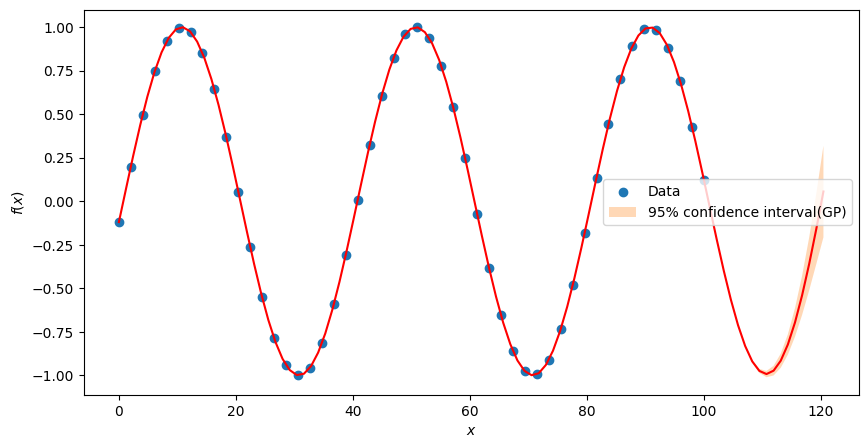

In [10]:
x, y = data_read('single')
x_true = x
x = x.reshape(-1,1)
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

In [11]:
x, y = data_read_test('single')

n_pred = 10
y_test_single = y[:-n_pred,:].T[0:2000]
y_fit_single = y[-n_pred:,:].T[0:2000]

RNN_X_single, RNN_Y_single, y_test_single = RNN_fitting(y_test_single, y_fit_single, n_pred)

(1600, 40)


2024-05-28 22:48:22.986843: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_2 (GRU)                 (None, 40, 16)            1632      
                                                                 
 gru_3 (GRU)                 (None, 14)                1344      
                                                                 
 dense (Dense)               (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1

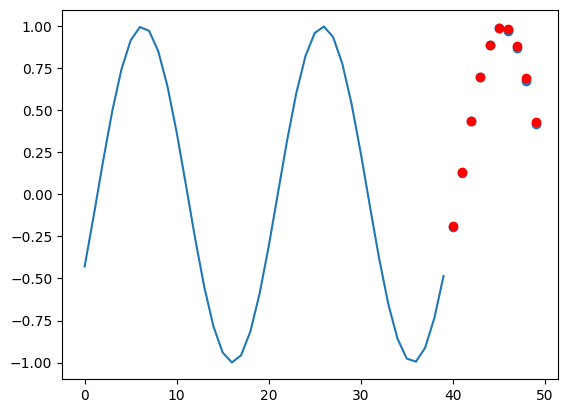

In [12]:
test = 0
plt.plot(RNN_X_single[test])
plt.scatter(range(50-n_pred,50), RNN_Y_single[test])
plt.scatter(range(50-n_pred,50), y_test_single[test], color = 'red')

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.73**2 * RBF(length_scale=40.6)


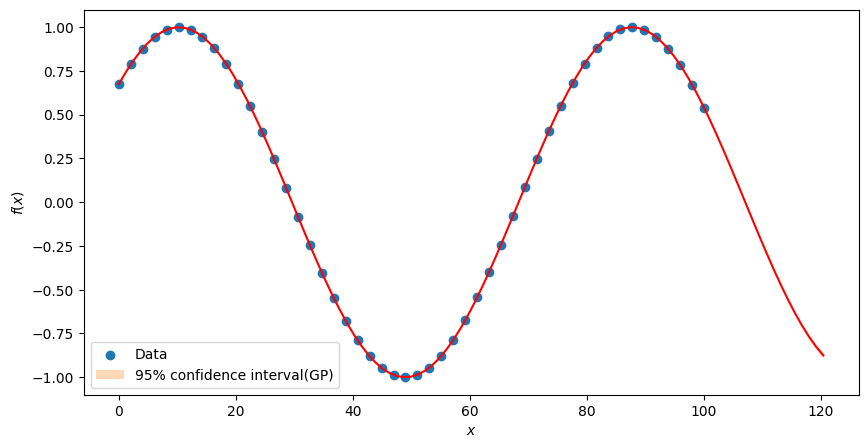

In [14]:
x, y = data_read('multiple')
x_true = x
x = x.reshape(-1,1)

n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_model.flatten(), y_model.flatten(), sigma, fit_unc)

In [15]:
x, y = data_read_test('multiple')

n_pred = 10
y_test_multiple = y[:-n_pred,:].T[0:2000]
y_fit_multiple = y[-n_pred:,:].T[0:2000]

RNN_X_multiple, RNN_Y_multiple, y_test_multiple = RNN_fitting(y_test_multiple, y_fit_multiple, n_pred)

(1600, 40)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 40, 32)            3360      
                                                                 
 gru_5 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_6 (GRU)                 (None, 40, 16)            1632      
                                                                 
 gru_7 (GRU)                 (None, 14)                1344      
                                                                 
 dense_1 (Dense)             (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [======================

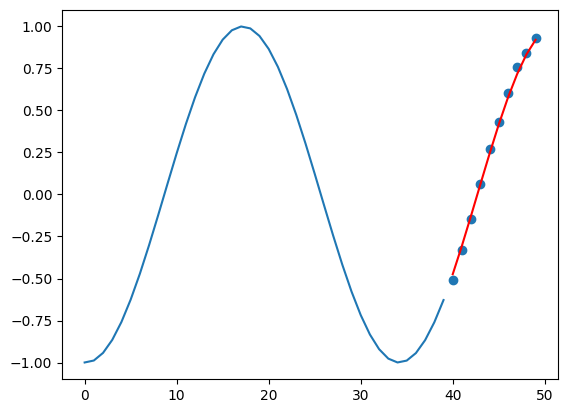

In [16]:
test = 0
plt.plot(RNN_X_multiple[test])
plt.scatter(range(40,50), RNN_Y_multiple[test])
plt.plot(range(40,50), y_test_multiple[test], color = 'red')

/opt/conda/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized hyper parameters:  4.59**2 * RBF(length_scale=40.1)


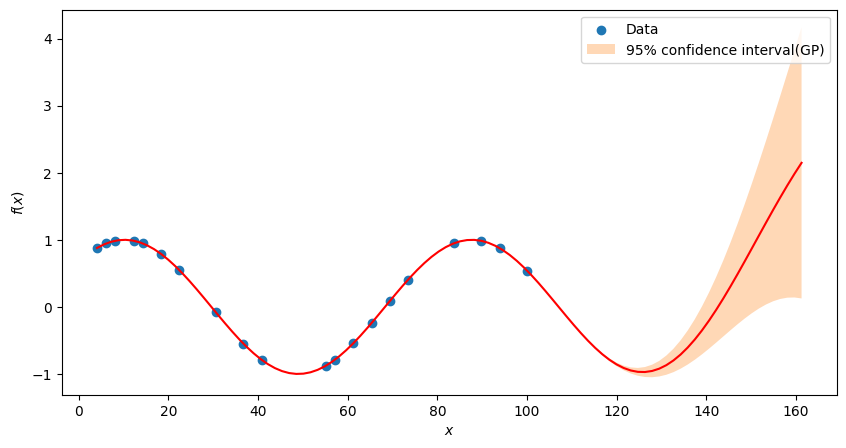

In [18]:
x, y = data_read('multiple_sampled')
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_model.flatten(), y_model.flatten(), sigma, fit_unc.flatten())

In [19]:
def sampled_interp(x, y):
    lc_sample = np.zeros_like(y.T)
    for i, lc in enumerate(y.T):
        #lc = np.asarray(lc)
        #print(x)
        #print(len(lc))
        #print(len(~np.isnan(lc)))
        #print(len(y))
        x_new = x[~np.isnan(lc)]
        lc_new = lc[~np.isnan(lc)]

        spl = interp1d(x_new, lc_new, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(x_new), max(x_new), 50)
        lc_sample[i] = spl(time_range)
    return(lc_sample)

In [20]:
x, y = data_read_test('multiple_sampled')

y = sampled_interp(x, y).T
n_pred = 10

y_test_input_MS = y[:-n_pred,:].T[0:2000]
y_fit_MS = y[-n_pred:,:].T[0:2000]

RNN_X_MS, RNN_Y_MS, y_test_MS = RNN_fitting(y_test_input_MS, y_fit_MS, n_pred)

(1600, 40)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 40, 32)            3360      
                                                                 
 gru_9 (GRU)                 (None, 40, 16)            2400      
                                                                 
 gru_10 (GRU)                (None, 40, 16)            1632      
                                                                 
 gru_11 (GRU)                (None, 14)                1344      
                                                                 
 dense_2 (Dense)             (None, 10)                150       
                                                                 
Total params: 8,886
Trainable params: 8,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
13/13 [======================

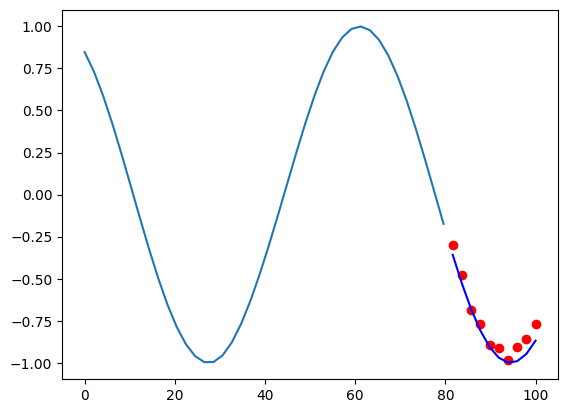

In [21]:
test = 50
t_space = np.linspace(0, 100, 50)
plt.plot(t_space[:-n_pred], RNN_X_MS[test])
plt.scatter(t_space[-n_pred:], RNN_Y_MS[test], color = 'red')
plt.plot(t_space[-n_pred:], y_test_MS[test], color = 'blue')

Optimized hyper parameters:  35**2 * RBF(length_scale=8.63)


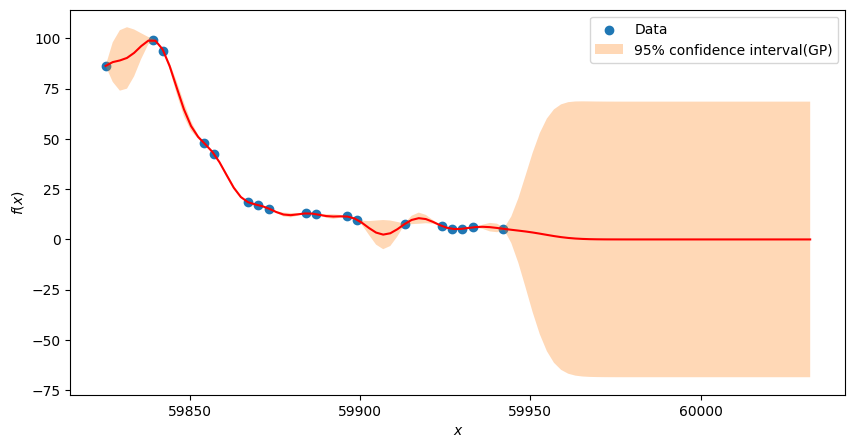

52


In [23]:
x, y, type_true = data_read('plasticc', image_number = 20)
x_true = x
x = x.reshape(-1,1)
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
n_points = 10

kernel = np.var(y) * k.RBF(length_scale=10.0)


x_pred, y_pred, sigma, optimizedParameters, x_model, y_model, fit_unc = gaussianProcess_fitting(x, y, kernel, n_pred = n_points)
print("Optimized hyper parameters: ", optimizedParameters)


plottingFits(x, y, x_model.flatten(), y_model.flatten(), sigma, fit_unc)
print(type_true)

In [24]:
def lf_processing(lcs):
    time_sample = np.zeros((len(lcs), 50))
    lc_sample = np.zeros((len(lcs), 50))

    for i, lc in enumerate(lcs):
        lc = np.asarray(lc)
        lc_timing = lc[:,0]
        lc_flux = lc[:,1]
        spl = interp1d(lc_timing, lc_flux, kind='cubic', fill_value= 'extrapolate')
        time_range = np.linspace(min(lc_timing), max(lc_timing), 50)
        processed_lc = spl(time_range)
        time_sample[i] = time_range
        lc_sample[i] = processed_lc
        
    return(lc_sample, time_sample)

In [31]:
lc_test, type_true = data_read('plasticc_test', image_number = 20)
lc_test = np.transpose((lf_processing(lc_test)), (1, 0, 2))

n_pred = 1
     
y_cat = (lc_test[:,0][:][:, -n_pred:])
lc_x = lc_test[:,0][:][:, :-n_pred]

RNN_X, RNN_Y, y_test = RNN_fitting(lc_x, y_cat, n_pred)

100%|██████████| 1135/1135 [00:00<00:00, 26355.90it/s]


(908, 49)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 49, 32)            3360      
                                                                 
 gru_17 (GRU)                (None, 49, 16)            2400      
                                                                 
 gru_18 (GRU)                (None, 49, 16)            1632      
                                                                 
 gru_19 (GRU)                (None, 14)                1344      
                                                                 
 dense_4 (Dense)             (None, 1)                 15        
                                                                 
Total params: 8,751
Trainable params: 8,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [=========================

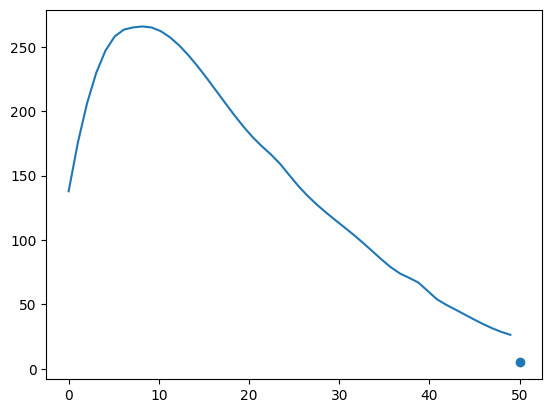

In [32]:
test = 100

t_space = np.linspace(0, 50, 50)
plt.plot(t_space[:-n_pred], RNN_X[test])
plt.scatter(t_space[-n_pred:], RNN_Y[test])